## Create dataset from original reports

The .csv dataset used in this report was created from the original PDF reports using the below code. Because of the size of the files, they could not be uploaded to Github. Instead, the created .csv is used.

In [26]:
# import pandas as pd
# import numpy as np
# import PyPDF2

In [27]:
# report_paths = ['OCR version - State Capture Commission Report Part 1 Vol I.pdf', 
#                 'OCR version - State Capture Commission Report Part II Vol II.pdf',
#                 'OCR version - State Capture Commission Report Part III Vol I - Bosasa.pdf',
#                 'OCR version - State Capture Commission Report Part III Vol II - Bosasa.pdf',
#                 'OCR version - State Capture Commission Report Part III Vol III - Bosasa.pdf',
#                 'OCR version - State Capture Commission Report Part III Vol IV - Bosasa.pdf',
#                 'OCR version - State Capture Commission Report Part IV Vol I - NT,EOH,COJ,Alexkor.pdf',
#                 'OCR version - State Capture Commission Report Part IV Vol II- FS.pdf',
#                 'OCR version - State Capture Commission Report Part IV Vol III - Eskom.pdf',
#                 'OCR version - State Capture Commission Report Part IV Vol IV - Eskom.pdf',
#                 'OCR version - State Capture Commission Report Part V Vol I - SSA.pdf',
#                 'OCR version - State Capture Commission Report Part V Vol II - SABC,Waterkloof,Prasa.pdf',
#                 'OCR version - State Capture Commission Report Part VI Vol I - Estina,Vrede.pdf',
#                 'OCR version - State Capture Commission Report Part VI Vol II - CR.pdf',
#                 'OCR version - State Capture Commission Report Part VI Vol III - Flow of Funds.pdf',
#                 'OCR version - State Capture Commission Report Part VI Vol IV - Recommendations.pdf']

# zondo_reports = pd.DataFrame(columns=['report', 'text'])
# i = 0

# for path in report_paths:
#    pdfFileObj = open(path, 'rb')
#    print('opened', path)
#    pdfReader = PyPDF2.PdfReader(pdfFileObj)
#    text=''
#    for page in pdfReader.pages:
#       text += page.extract_text()
#    print('extracted text for', path)
#    zondo_reports.loc[i] = [path, text]
#    i+=1
#    pdfFileObj.close()
#    print('closed', path)

In [28]:
# zondo_reports.to_csv('zondo_reports.csv')

## Data mining

In [29]:
# import required libraries

import nltk
import numpy
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import pandas as pd

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.probability import FreqDist

import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ezeyn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ezeyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# these are the companies listed on the Johannesburg Stock Exchange (JSE)
listed_companies = pd.read_excel('Complete-List-of-Listed-Companies-on-South-Africa-Johannesburg-Stock-Exchange-Jan-2021.xlsx')
listed_companies = listed_companies.rename(columns={'Company Name': 'CompanyName'})
listed_companies.head()

,S.No.,CompanyName,Ticker,Sector
0,1,4Sight Holdings Limited,4SI,Financial Services
1,2,ABSA Bank Limited,ABSP,Banks
2,3,Barclays Africa Group Limited,ABG.ZA,Banks
3,4,Accelerate Property Fund Limited,APF,Real Estate Investment Trusts
4,5,Accentuate Limited,ACE,Chemicals


In [31]:
# ensure there are no duplicates
companies = list(listed_companies['CompanyName'].unique())

In [32]:
# load the Zondo Comission reports into a dataframe
url = 'https://raw.githubusercontent.com/mrzeynalli/Python/main/Zondo%20Reports%20Analysis/zondo_reports.csv'
zondo_reports = pd.read_csv(url)
zondo_reports = zondo_reports.drop(columns=['Unnamed: 0'])
zondo_reports.head()

,report,text
0,OCR version - State Capture Commission Report ...,dicial \nn of Ir• \nS a \nI I eport: Part 1 \n...
1,OCR version - State Capture Commission Report ...,Judicial Commission \nOf \n Inquiry into...
2,OCR version - State Capture Commission Report ...,\n \nJudicial Commission \nof \nInquiry into...
3,OCR version - State Capture Commission Report ...,Chairperson: Justice RtM Zondo \nActing Chief ...
4,OCR version - State Capture Commission Report ...,\n \nJudicial Commission \nof \nInquiry into...


In [33]:
# consolidate the content of all report volumes into a list
content = zondo_reports['text'].to_list()

In [34]:
# join items in content list as a literal string, then tokenize
all_content = " ".join(content[:])
all_content_tokens = word_tokenize(all_content) 

# Note: We do not lowercase the tokens, as we are looking for company names which are proper nouns.

## Data cleaning and processing

In [35]:
# remove some stops from the tokens
junk_tokens = ['mr','ms','dr','p','``', '\'s','’','’’','\'\'','“','”','................................','l']

removables = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + junk_tokens)

filtered_tokens = [token for token in all_content_tokens if token not in removables]

In [36]:
# There is a strong chance that when the reports mention company names, they don't use their full listed names.
# For example, from reading a part of one report, the bank 'Nedbank Limited' is referred to as just 'Nedbank'.
# We define a new list of stops for terms that are likely not to be mentioned.

stops = ['Holdings', 'Limited', 'Ltd', 'Plc', 'plc', 'Group', 'Company', 'Fund', 'Corporation', 'Corp', 'Investments', 'Compagnie Financiere', 'Ld', 'International', 'NV']


In [37]:
# We then define a function that removes the stops from the company names and 
# stores them as tuples based on how many words make up the company name. 
# This will help us search for the names in the text either as single words, 
# bigrams, or trigrams. The function returns a search term.

def search_term(name: str):
    for stop in stops:
        name = name.replace(stop, '')
        name = name.strip()
    
    if len(name.split()) == 1:
        name = tuple(name.split(' '))
        return name
    elif len(name.split()) == 2:
        name = tuple(name.split(' '))
        return name
    elif len(name.split()) == 3:
        name = tuple(name.split(' '))
        return name
    else: 
        # if more than three words, use first three words anyway. 
        first_three_words = ' '.join(name.split()[:3])
        first_three_words = tuple(first_three_words.split(' '))
        return first_three_words

In [38]:
# Populate the SearchTerm column with the search_terms derived from each company name.
listed_companies['SearchTerm'] = listed_companies.apply(lambda row : search_term(row['CompanyName']), axis = 1)

## Analysis

In [39]:
# Bigrams and trigrams are created to search for two-word and three-word search terms individually.
bigrams = list(nltk.bigrams(filtered_tokens)) 
trigrams = list(nltk.trigrams(filtered_tokens)) 

# Create new column that will store whether a company name is mentioned or not.
listed_companies["FoundInReport"] = "False"



for ind in listed_companies.index:
    searchterm = listed_companies['SearchTerm'][ind]
    if len(searchterm) == 1:
        if searchterm[0] in filtered_tokens:
            # search for one-word search terms
            print('1 word company appeared in text:', searchterm)
            listed_companies.at[ind,'FoundInReport'] = True
    if len(searchterm) == 2:
        if searchterm in bigrams:
            # search for two-word search terms
            print('2 word company appeared in text:', searchterm)
            listed_companies.at[ind,'FoundInReport'] = True
    if len(searchterm) == 3:
        if searchterm in trigrams:
            # search for three-word search terms
            print('3 word company appeared in text:', searchterm)
            listed_companies.at[ind,'FoundInReport'] = True

2 word company appeared in text: ('ABSA', 'Bank')
2 word company appeared in text: ('Barclays', 'Africa')
2 word company appeared in text: ('African', 'Bank')
2 word company appeared in text: ('Anglo', 'American')
1 word company appeared in text: ('Bid',)
3 word company appeared in text: ('Blue', 'Label', 'Telecoms')
3 word company appeared in text: ('Caxton', 'CTP', 'Publishers')
1 word company appeared in text: ('Command',)
1 word company appeared in text: ('Efficient',)
1 word company appeared in text: ('EOH',)
1 word company appeared in text: ('Firstrand',)
1 word company appeared in text: ('Glencore',)
1 word company appeared in text: ('Five',)
2 word company appeared in text: ('Impala', 'Platinum')
1 word company appeared in text: ('Imperial',)
1 word company appeared in text: ('Hotel',)
1 word company appeared in text: ('Investec',)
1 word company appeared in text: ('Investec',)
1 word company appeared in text: ('ISA',)
1 word company appeared in text: ('JSE',)
1 word company ap

In [40]:
# making a new dataframe entailing only mentioned companies
mentioned_comapanies_df = listed_companies[listed_companies['FoundInReport'] == True].reset_index(drop=True) # reseting the index

In [41]:
one_word_frequencies = FreqDist(filtered_tokens)
one_word_frequencies = {tuple([key]):value for key,value in one_word_frequencies.items()}
# as the single worded 'SearchTerm' values are tuples in the dataframe, it was needed to convert the keys of one_word_ 
# _frequencies variable values into tuple format from string

two_words_frequencies = FreqDist(bigrams)
three_words_frequencies = FreqDist(trigrams) # keys of two_ and three_words_frequencies variables are tuples by nature

In [42]:
def search_freq(name):
    if len(name) == 1:
        freq = one_word_frequencies[name]
        return freq
    elif len(name) == 2:
        freq = two_words_frequencies[name]
        return freq
    elif len(name) == 3:
        freq = three_words_frequencies[name]
        return freq

In [43]:
# Make a dataframe that stores the companies whose names were mentioned in the reports
mentioned_comapanies_df['MentionsFrequency'] = mentioned_comapanies_df.apply(lambda row : search_freq(row['SearchTerm']), axis = 1)
mentioned_comapanies_df.sort_values(by='MentionsFrequency',ascending=False).head(10)

In [46]:
# After observing the mentioned_companies dataframe, it is quite visible that some company names are commonly used English words (e.g. 'Sun','Hotel', and etc.).
# We might have erroneously found words that are starts of sentences (recall that we are finding proper nouns). 
# To fix this, we import a list of english words to perform a crosscheck. 

# Install english_words if needed
# !pip install english_words
from english_words import english_words_set

english_words_set_cap = [word.title() for word in english_words_set]

In [47]:
# looking for whether the candidate companies appear in the reports with their second word 
for search_term in mentioned_comapanies_df['SearchTerm']:
    if len(search_term) == 1:
    # Look conitionally for the companies whose search_term is one  word
    
        if search_term[0] in english_words_set_cap:
        # Set a condition for whether that search term is included in English words set
            
            # Add the second word of the company to its serch term
            comp_name = mentioned_comapanies_df[mentioned_comapanies_df['SearchTerm'] == search_term]['CompanyName'].iloc[0]
            comp_name_first_two_words = tuple(comp_name.split(' ')[:2])
            freq = two_words_frequencies[comp_name_first_two_words] # serching them in two words frequencies
            # Print if the candidate compaies appear in the reports alongside with their second word
            print(f'{comp_name_first_two_words} is mentioned {freq} times')

('Bid', 'Corp') is mentioned 0 times
('Command', 'Holdings') is mentioned 0 times
('Efficient', 'Group') is mentioned 0 times
('Group', 'Five') is mentioned 0 times
('Imperial', 'Holdings') is mentioned 0 times
('International', 'Hotel') is mentioned 0 times
('Lewis', 'Group') is mentioned 0 times
('Liberty', 'Holdings') is mentioned 0 times
('Sun', 'International') is mentioned 0 times
('Value', 'Group') is mentioned 0 times


In [48]:
# As none of the companies whose name starts with common English words are mentioned in the report,
# they need to be removed from the final list.
 
def return_index(search_term, column, dataframe):
    # This function returns the index of the company name by searching for its search_term
    cell_index = dataframe[dataframe[column] == search_term].index
    return cell_index


In [49]:
removable_indices = [] # this stores the indices for the candidate companies

for search_term in mentioned_comapanies_df['SearchTerm']:
    if len(search_term) == 1:
    # Look conitionally for the companies whose search_term is one  word

        if search_term[0] in english_words_set_cap:
        # Set a condition for whether that search term is included in English words set
        
            removable_indices.append(return_index(search_term,'SearchTerm',mentioned_comapanies_df))
            # Add the index of the candidate company to the list

for index in removable_indices:
    # remove the candidate company rows from the dataframe
    mentioned_comapanies_df.drop(index,axis=0,inplace=True)

In [50]:
# reset indices and sort by MentionsFrequency
mentioned_comapanies_df = mentioned_comapanies_df.reset_index(drop=True)
mentioned_comapanies_df.sort_values(by='MentionsFrequency',ascending=False).head(10)

,S.No.,CompanyName,Ticker,Sector,SearchTerm,FoundInReport,MentionsFrequency
8,154,Glencore Plc,GLN,Mining,"(Glencore,)",True,190
25,345,Standard Bank Group Limited,SBK,Banks,"(Standard, Bank)",True,119
18,254,Nedbank Group Limited,NED,Banks,"(Nedbank,)",True,114
6,133,EOH Holdings Limited,EOH,Software & Computer Services,"(EOH,)",True,107
16,249,MultiChoice Group Limited,MCG,Media,"(MultiChoice,)",True,67
10,193,Investec Limited,INL,Financial Services,"(Investec,)",True,14
11,194,Investec Plc,INP,Financial Services,"(Investec,)",True,14
23,330,Sasol Limited,SOL,Oil & Gas Producers,"(Sasol,)",True,11
17,253,Naspers Limited,NPN,Media,"(Naspers,)",True,8
27,390,Vodacom Group Limited,VOD,Mobile Telecommunications,"(Vodacom,)",True,7


In [51]:
# Create new series grouped by sectors and their MentionsFrequency
sector_freqs = mentioned_comapanies_df.groupby('Sector').sum().sort_values(by='MentionsFrequency',ascending=False)['MentionsFrequency']
sector_freqs.head()

C:\Users\ezeyn\AppData\Local\Temp\ipykernel_16244\2679449437.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sector_freqs = mentioned_comapanies_df.groupby('Sector').sum().sort_values(by='MentionsFrequency',ascending=False)['MentionsFrequency']


Sector
Banks                           236
Mining                          197
Software & Computer Services    110
Media                            76
Financial Services               34
Name: MentionsFrequency, dtype: int64

## Visualization

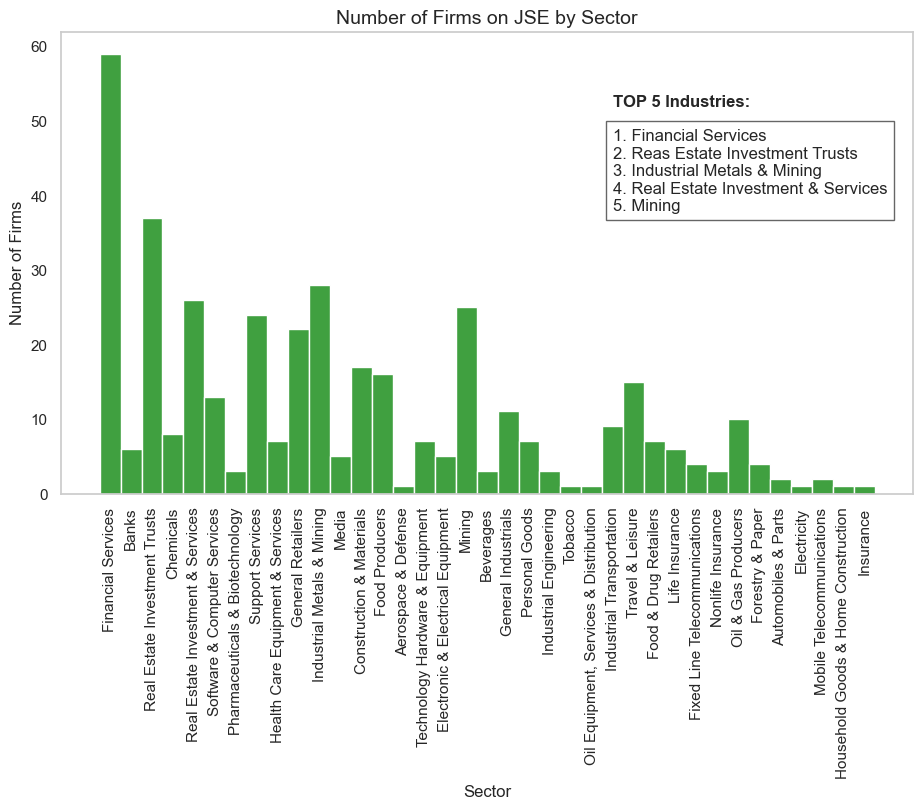

In [102]:
# Formulate a histogram to display number of firms in JSE by sector

fig, subfig = plt.subplots(figsize=(11,6))

# Create a histogram by using seaborn library
sns.histplot(data=listed_companies, x="Sector",color='Green')

# Add in-chart text indicating the TOP 5 Industries 
plt.text(24,52,
'TOP 5 Industries:'
,weight="bold")

plt.text(24,38,
'1. Financial Services\n2.'
' Reas Estate Investment Trusts\n3. Industrial Metals & Mining\n4. Real Estate Investment & Services\n5. Mining'
,weight="regular",bbox = dict(edgecolor = 'black',facecolor = 'white', alpha = 0.6, pad = 5))


plt.title('Number of Firms on JSE by Sector',fontsize=14)
plt.ylabel('Number of Firms')
plt.grid(False)

# Rotate x lables by 90 degrees to make it more readable
rotated_ticks = plt.xticks(rotation=90)

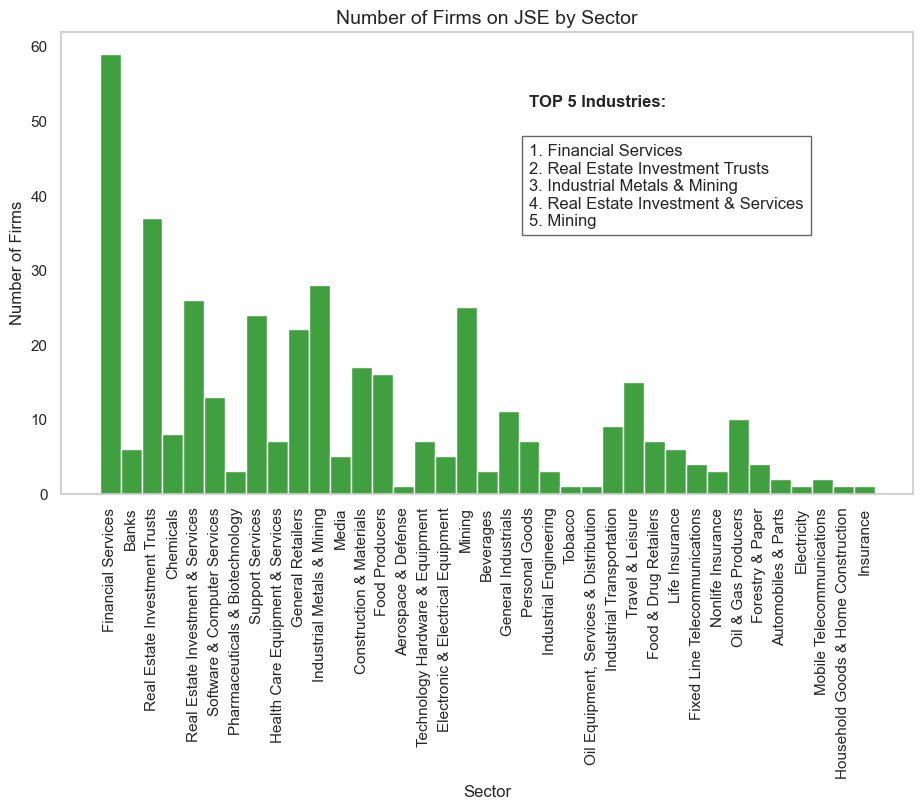

In [103]:
# Formulate a histogram to display number of firms in JSE by sector

fig, subfig = plt.subplots(figsize=(11,6))

# Create a histogram by using seaborn library
sns.histplot(data=listed_companies, x="Sector",color='Green')

# Add in-chart text indicating the TOP 5 Industries 
plt.text(20,52,
'TOP 5 Industries:'
,weight="bold")

top_5_industries = list(listed_companies.groupby('Sector').count()['Ticker'].sort_values(ascending=False)[:5].index)

plt.text(20,36,
f'1. {top_5_industries[0]}\n'
f'2. {top_5_industries[1]}\n'
f'3. {top_5_industries[2]}\n'
f'4. {top_5_industries[3]}\n'
f'5. {top_5_industries[4]}'
,weight="regular",bbox = dict(edgecolor = 'black',facecolor = 'white', alpha = 0.6, pad = 5))


plt.title('Number of Firms on JSE by Sector',fontsize=14)
plt.ylabel('Number of Firms')
plt.grid(False)

# Rotate x lables by 90 degrees to make it more readable
rotated_ticks = plt.xticks(rotation=90)

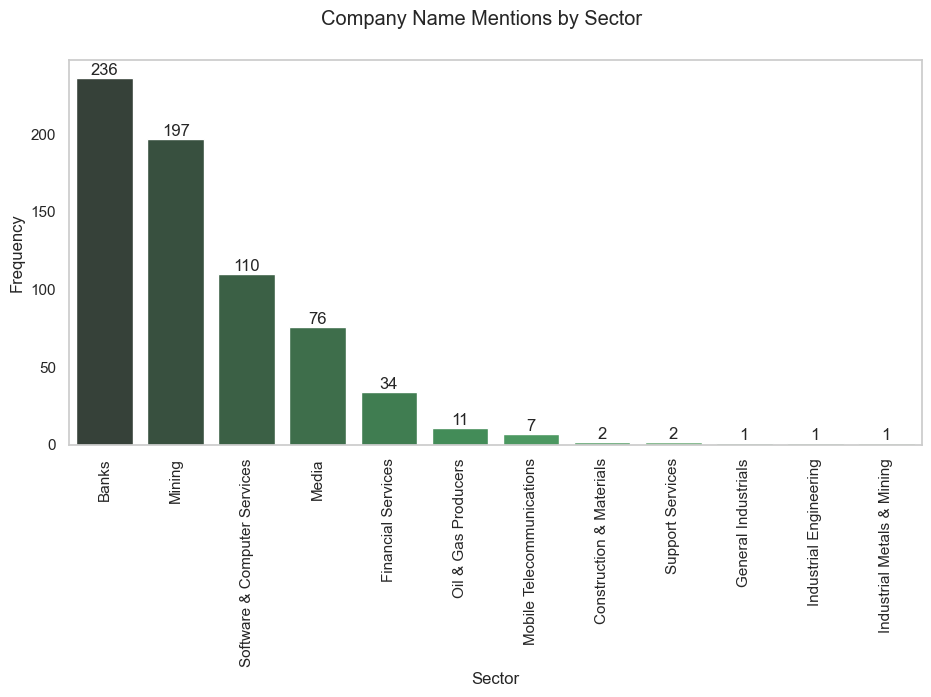

In [54]:
# Visualise the mostly mentioned companies by their sectors
fig, subfig = plt.subplots(figsize=(11,5))

# Create a palette coloring: colors gets lighter as the values go lower
palette = sns.color_palette("Greens_d",n_colors=len(sector_freqs.index))
palette.reverse()

plt.grid(False)

fig.suptitle(t='Company Name Mentions by Sector',x=0.5,y=0.98)
subfig.set_ylabel("Frequency")

#Create a bar plot by using seaborn library
opening = sns.barplot(x=sector_freqs.index, y=sector_freqs.values, palette=palette)

# Rotate x lables by 90 degrees to make it more readable
ticks = opening.set_xticklabels(labels=sector_freqs.index,rotation=90)

# Add bar labels showing the values for each label
bar_labels = opening.bar_label(container=opening.containers[0],label_type='edge')

# Report

## Analysis of Zondo Report: Ethical investment decision in South Africa

In 2018, former President of South Africa, Jacob Zuma, established a commission of enquiry in state capture, known as [The Judicial Commission of Inquiry into Allegations of State Capture, Corruption and Fraud in the Public Sector including Organs of State](https://www.statecapture.org.za/), or simply the Zondo Commission. The commission collected one exabyte of evidence, and on 22 June 2022 released its final report. 

Among the guilty parties mentioned in the [reports](https://www.statecapture.org.za/site/information/reports), are publicly listed companies on the [Johannesburg Stock Exchange](https://www.jse.co.za/), which form part of many investment portfolios. This report aims to identify which of these companies are potentially implicated to inform ethical investment decision making.

From the analysis, it is evident that the banking industry has the highest number of mentions in the revealing reports, followed by Mining, Software&Computer Services, and Media industries. Reputable SA banks like “Standard Bank”, “Nedbank” and three others contributed to 236 mentions in total. “Glenmore Plc”, “EOH Holding Limited”, and “MultiChoice Group Limited” are the main non-bank companies mentioned noticeably in the reports, being mentioned 190, 107, and 67 times, respectively. Two companies from Financial Services industry – "Investec Limited" and "Investec Plc" – have been mentioned 14 times each. Oil-gas firm “Sasol Limited” is found to be mentioned 11 times.

Fund managers should carry out additional research to make the most prudent and ethical investment decision.